In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip ./drive/MyDrive/images.zip -d ./data/
!unzip ./drive/MyDrive/masks.zip -d ./data/
!unzip ./drive/MyDrive/train.csv.zip -d ./data/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./data/masks/ID00290637202279304677843_mask_154.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_155.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_156.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_157.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_158.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_159.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_16.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_160.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_161.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_162.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_163.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_164.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_165.jpg  
  inflating: ./data/masks/ID00290637202279304677843_mask_166.j

In [3]:
!pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=7bd4eed3ccfe8314db6a3c1f5b25a36366f7df2891f0cd0fecaae03766da7ac5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b5589f93af9fa2a98376ae6651f284eb10d661565d8c8f5cf5cb39df8aed0bfe
  Stored in directory: /root/.cache/pip/w

In [4]:
import os

from tqdm import tqdm

from typing import Callable, Tuple, Any

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import JaccardLoss, DiceLoss

import albumentations as A
from albumentations.pytorch import ToTensorV2 
from albumentations import (HorizontalFlip,
                            VerticalFlip,
                            Normalize,
                            Compose)

import matplotlib.pyplot as plt

import cv2

In [5]:
class LungsDataset(Dataset):
    def __init__(self,
                 img_dir: str,
                 mask_dir: str,
                 file_list: pd.DataFrame,
                 transform: Callable) -> None:
        super().__init__()
        
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform

    def __getitem__(self, index) -> Tuple:
        img_name = self.file_list.loc[index, "ImageId"]
        mask_name = self.file_list.loc[index, "MaskId"]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        mask = mask[:,:,0]
        mask[mask < 240] = 0
        mask[mask > 0] = 1
        
        transformed = self.transform(image = img, mask = mask.astype(np.float32))

        img = transformed['image']
        mask = transformed['mask']

        return img, mask
        
    def __len__(self) -> int:
        return len(self.file_list)

In [6]:
BATCH_SIZE = 8

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    Normalize(mean=mean, std=std, p=1),
    VerticalFlip(p=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    Normalize(mean=mean, std=std, p=1),
    ToTensorV2(),
])

img_dir = "./data/images/"
mask_dir = "./data/masks/"
file_list = pd.read_csv("./data/train.csv")


train_list, val_list = train_test_split(file_list, test_size=0.2)
train_list, val_list = train_list.reset_index(drop=True), val_list.reset_index(drop=True)

train_dataset = LungsDataset(img_dir, mask_dir, train_list, train_transform)
val_dataset = LungsDataset(img_dir, mask_dir, val_list, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for batch_imgs, batch_labels in tqdm(loader):
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        batch_outputs = model(batch_imgs)
        batch_loss = criterion(batch_outputs, batch_labels)
        batch_loss.backward()
        optimizer.step()
        
        epoch_loss += batch_loss.detach()
        
    epoch_loss /= len(loader)
    
    return epoch_loss

def val_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    for batch_imgs, batch_labels in loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        
        with torch.no_grad():
            batch_outputs = model(batch_imgs)
            batch_loss = criterion(batch_outputs, batch_labels)
        
        epoch_loss += batch_loss.detach()
    
    epoch_loss /= len(loader)
    
    return epoch_loss

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = val_epoch(model, val_loader, criterion, device)
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; val loss: {val_loss:.3f}')

In [9]:
model = Unet('efficientnet-b2', encoder_weights="imagenet")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:02<00:00, 17.8MB/s]


In [10]:
jaccard_loss = JaccardLoss(mode='binary')
dice_loss = DiceLoss(mode='binary')

adam = Adam(model.parameters())

In [11]:
num_epochs = 4
train(model=model, 
      train_loader = train_loader, 
      val_loader = val_loader, 
      num_epochs = num_epochs, 
      criterion = dice_loss, 
      optimizer = adam,
      device = device
)

100%|██████████| 1671/1671 [16:45<00:00,  1.66it/s]


[Epoch 1] train loss: 0.132; val loss: 0.106


100%|██████████| 1671/1671 [16:37<00:00,  1.68it/s]


[Epoch 2] train loss: 0.108; val loss: 0.108


100%|██████████| 1671/1671 [16:37<00:00,  1.68it/s]


[Epoch 3] train loss: 0.106; val loss: 0.096


100%|██████████| 1671/1671 [16:36<00:00,  1.68it/s]


[Epoch 4] train loss: 0.091; val loss: 0.090


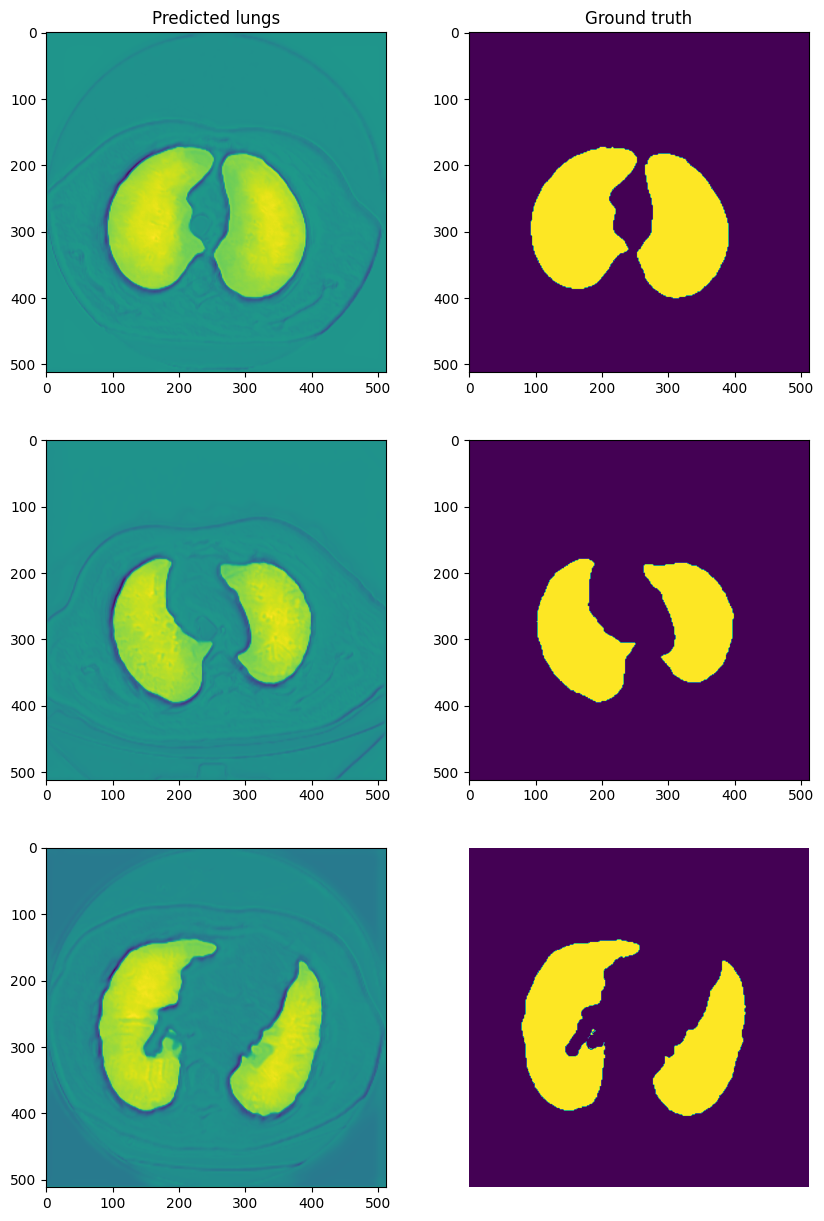

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,15))

numbers = [20, 30, 40]

for idx, num in enumerate(numbers):
    val_img, val_mask = val_dataset.__getitem__(num)
    val_img = val_img.to(device)
    val_img = val_img.unsqueeze(0)

    val_output = model(val_img)

    axes[idx, 0].imshow(val_output.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))
    axes[idx, 1].imshow(val_mask.numpy())

axes[0,0].set_title('Predicted lungs')
axes[0,1].set_title('Ground truth')

plt.axis('off')
plt.show()

In [14]:
torch.save(model.state_dict(), 'segmentation_model_weight.pth')